In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#from pandas.tools.plotting import parallel_coordinates
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

from tensorflow.python.framework import ops
ops.reset_default_graph()


In [2]:
data = pd.read_csv('/home/miles/Downloads/HR_comma_sep.csv')
header = data.columns

In [3]:
for idx, col in enumerate(data.columns):
    print('%d: %s' %(idx, col))

0: satisfaction_level
1: last_evaluation
2: number_project
3: average_montly_hours
4: time_spend_company
5: Work_accident
6: left
7: promotion_last_5years
8: sales
9: salary


In [4]:
# Create encoder maps for categorical data
department_map = { val:idx for idx, val in enumerate(data['sales'].drop_duplicates().values)}
salary_map = {val:idx for idx, val in enumerate(data['salary'].drop_duplicates().values)}

# Apply encoder maps to categorical data
data['sales'] = data['sales'].apply(lambda x: department_map.get(x, None))
data['salary'] = data['salary'].apply(lambda x: salary_map.get(x, None))

# OneHotEncoding of categorical data
data_enc = pd.get_dummies(data, columns=['sales', 'salary'])

In [5]:
# slice targets
Y = data_enc['left']

# drop target columns
if 'left' in data_enc.columns:
    data_enc = data_enc.drop('left', axis=1)


# rescale remaining data; (x[i] - mu) / sigma
X = StandardScaler().fit_transform(data_enc)


# Dimensions of layers
# N, D, M, K
N, D = X.shape
M = D + 3
K = 2

# Targets
T = np.zeros((N, K))
for i in range(N):
    T[i, Y[i]] = 1
    

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, T, test_size=0.20, random_state=42)

In [37]:
print('Training')
print('\tShape of X_train: ', X_train.shape)
print('\tShape of y_train: ', y_train.shape)
print('Testing')
print('\tShape of X_test: ', X_test.shape)
print('\tShape of y_test: ', y_test.shape)

Training
	Shape of X_train:  (11999, 20)
	Shape of y_train:  (11999, 2)
Testing
	Shape of X_test:  (3000, 20)
	Shape of y_test:  (3000, 2)


In [6]:
# Create the graph session
sess = tf.Session()

In [7]:
# Define Variable functions (weights and bias)
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, mean=0.0, stddev=0.01))

def init_bias(shape):
    return tf.Variable(tf.zeros(shape))


In [8]:
# Create placeholders for input & output
tfX = tf.placeholder(shape=[None, D], dtype=tf.float32)
tfY = tf.placeholder(shape=[None, K], dtype=tf.float32)

In [9]:
# Create fully connected layer
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return (tf.nn.relu(layer))

In [10]:
# Create hidden layer
W1 = init_weights([D, M])
b1 = init_bias([M])
hidden_1 = fully_connected(tfX, W1, b1)

# Output layer
W2 = init_weights([M, K])
b2 = init_bias([K])
output_layer = fully_connected(hidden_1, W2, b2)

In [11]:
# Declare loss function (L1)
loss = tf.reduce_mean(tf.pow(tf.abs(tfY - output_layer), 2))

In [12]:
# Delcare optimizer
my_opt = tf.train.AdamOptimizer(0.05)
train_step = my_opt.minimize(loss)

In [13]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

In [14]:
# Training loop
loss_vec = []
test_loss = []
batch_size = 100
for i in range(30001):
    rand_index = np.random.choice(len(X_train), size=batch_size)
    rand_x = X_train[rand_index]
    rand_y = y_train[rand_index]
    sess.run(train_step, feed_dict={tfX: rand_x, tfY: rand_y})
    
   
    if i % 300 == 0:
        temp_loss = sess.run(loss, feed_dict={tfX: rand_x, tfY: rand_y})
        loss_vec.append(temp_loss)
    
        test_temp_loss = sess.run(loss, feed_dict={tfX: X_test, tfY: y_test})
        test_loss.append(test_temp_loss)
        #print('Generation: %8d\t Loss = %8.4f' % (i, temp_loss))
        

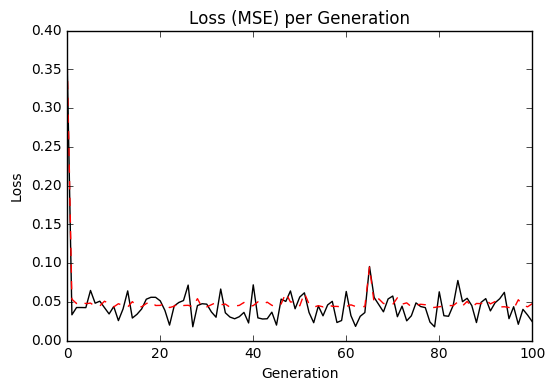

In [15]:
# Plot loss (MSE) over time
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show();

In [16]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [17]:
pred = clf.predict(X_test)

In [18]:
(pred == y_test).mean()

0.97466666666666668

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

# build the forest
forest = ExtraTreesClassifier(n_estimators=250, random_state=42)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

In [20]:
importances

array([ 0.23529296,  0.13232394,  0.23823608,  0.14482066,  0.1671901 ,
        0.01940905,  0.00314308,  0.00532889,  0.00322781,  0.00331541,
        0.00519291,  0.00476778,  0.00245096,  0.00319586,  0.00281625,
        0.00248645,  0.00363526,  0.01079543,  0.00481061,  0.00756051])

In [21]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [22]:
indices = np.argsort(importances)[::-1]

In [23]:
print('Feature Ranking:')

Feature Ranking:


In [24]:
np.mean(forest.predict(X_test) == y_test)

0.98499999999999999

1. feature 2 (0.238236)
2. feature 0 (0.235293)
3. feature 4 (0.167190)
4. feature 3 (0.144821)
5. feature 1 (0.132324)
6. feature 5 (0.019409)
7. feature 17 (0.010795)
8. feature 19 (0.007561)
9. feature 7 (0.005329)
10. feature 10 (0.005193)
11. feature 18 (0.004811)
12. feature 11 (0.004768)
13. feature 16 (0.003635)
14. feature 9 (0.003315)
15. feature 8 (0.003228)
16. feature 13 (0.003196)
17. feature 6 (0.003143)
18. feature 14 (0.002816)
19. feature 15 (0.002486)
20. feature 12 (0.002451)


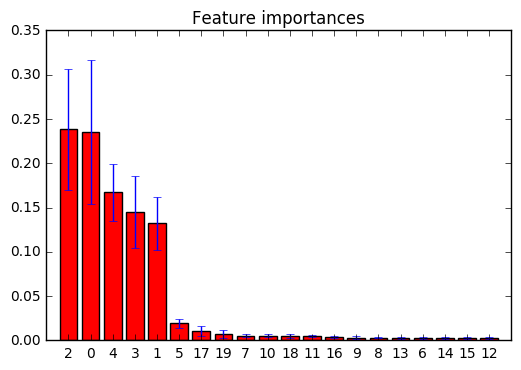

In [25]:
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [26]:
#data_enc.apply( lambda x: (x - np.mean(x))/ np.std(x),axis=0)
for i, c in enumerate(data_enc.columns):
    print(i,' : ', c)

0  :  satisfaction_level
1  :  last_evaluation
2  :  number_project
3  :  average_montly_hours
4  :  time_spend_company
5  :  Work_accident
6  :  promotion_last_5years
7  :  sales_0
8  :  sales_1
9  :  sales_2
10  :  sales_3
11  :  sales_4
12  :  sales_5
13  :  sales_6
14  :  sales_7
15  :  sales_8
16  :  sales_9
17  :  salary_0
18  :  salary_1
19  :  salary_2


In [27]:
X_train[:3]

array([[ 1.5572472 , -0.61988566, -0.65153764, -0.26131281,  0.34365527,
        -0.41116529, -0.14741182, -0.61745492, -0.23214788, -0.22764728,
        -0.4706553 , -0.41779149, -0.20939051, -0.29848587,  3.95330281,
        -0.24632222, -0.2353205 ,  1.02477511, -0.8681323 , -0.29980859],
       [-1.82137084,  0.3733173 ,  0.15978764, -0.10112518,  1.02854571,
        -0.41116529, -0.14741182, -0.61745492, -0.23214788, -0.22764728,
         2.12469721, -0.41779149, -0.20939051, -0.29848587, -0.25295305,
        -0.24632222, -0.2353205 , -0.97582386, -0.8681323 ,  3.33546146],
       [ 0.75281433,  0.49016471, -0.65153764, -0.52161771, -1.0261256 ,
        -0.41116529, -0.14741182, -0.61745492, -0.23214788, -0.22764728,
        -0.4706553 , -0.41779149, -0.20939051, -0.29848587, -0.25295305,
        -0.24632222,  4.24952348, -0.97582386,  1.15189816, -0.29980859]])

In [28]:
def forward(X, W1, b1, W2, b2):
    Z = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
    return tf.matmul(Z, W2) + b2

In [29]:
logits = forward(tfX, W1, b1, W2, b2)

In [30]:
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
    labels=tfY, logits=logits))

In [31]:
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(cost)

predict_op = tf.argmax(logits, 1)

In [32]:
init = tf.global_variables_initializer()
sess.run(init)

In [33]:
epoch = []
accuracy = []
for i in range(20001):
    sess.run(train_op, feed_dict={tfX: X_train, tfY: y_train})
    pred = sess.run(predict_op, feed_dict={tfX: X_train, tfY: y_train})
    if i % 500 == 0:
        epoch.append(i)
        acc = np.mean(y_train == pred)
        accuracy.append(acc)
    if i % 2000 == 0:
        print('Epoch: %d\tAccuracy: %.4f' %(i, accuracy[-1]))
    

/home/miles/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Epoch: 0	Accuracy: 0.0000
Epoch: 2000	Accuracy: 0.0000
Epoch: 4000	Accuracy: 0.0000
Epoch: 6000	Accuracy: 0.0000
Epoch: 8000	Accuracy: 0.0000
Epoch: 10000	Accuracy: 0.0000


KeyboardInterrupt: 

In [34]:
plt.plot(epoch, accuracy)

# Parallel Coordinates

In [35]:
df = pd.DataFrame(data_scale, columns=header)

NameError: name 'data_scale' is not defined

In [ ]:
plt.figure(figsize=(11, 8))
parallel_coordinates(df, 'left')

plt.savefig('parcoor_hr.png', dpi=800)

plt.show()

In [ ]:
data.head()

In [ ]:
data_scale[0]

In [ ]:
import numpy as np
np.unique(data_scale[:, -4])